# Sentiment Analysis with NLP

This notebook demonstrates sentiment analysis on customer reviews using TF-IDF vectorization and Logistic Regression.

## 1. Import Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set random seed for reproducibility
np.random.seed(42)

# Set up visualization settings
plt.style.use('ggplot')
%matplotlib inline

In [2]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\Gayathri
[nltk_data]     Prasad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Gayathri
[nltk_data]     Prasad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Gayathri
[nltk_data]     Prasad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 2. Load and Explore the Dataset

For this demonstration, I create a sample dataset of customer reviews.

In [3]:
# Create a sample dataset of customer reviews
data = {
    'review': [
        "This product is amazing! I love it so much.",
        "Worst purchase ever. Complete waste of money.",
        "The quality is good but shipping took too long.",
        "I'm very satisfied with my purchase, would buy again.",
        "Terrible customer service, will never shop here again.",
        "The product works as expected, good value for money.",
        "Not worth the price, very disappointed.",
        "Excellent product and fast delivery!",
        "The item arrived damaged and customer service was unhelpful.",
        "Average product, nothing special about it.",
        "This exceeded my expectations, highly recommend!",
        "Defective product, had to return it immediately.",
        "Good quality but a bit overpriced.",
        "Love everything about this product, perfect purchase!",
        "Misleading description, the product is much smaller than advertised."
    ],
    'sentiment': [
        'positive',
        'negative',
        'neutral',
        'positive',
        'negative',
        'positive',
        'negative',
        'positive',
        'negative',
        'neutral',
        'positive',
        'negative',
        'neutral',
        'positive',
        'negative'
    ]
}

df = pd.DataFrame(data)
df.head()

,review,sentiment
0,This product is amazing! I love it so much.,positive
1,Worst purchase ever. Complete waste of money.,negative
2,The quality is good but shipping took too long.,neutral
3,"I'm very satisfied with my purchase, would buy...",positive
4,"Terrible customer service, will never shop her...",negative


In [4]:
# Basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nDataset info:")
df.info()
print("\nSentiment distribution:")
print(df['sentiment'].value_counts())

Dataset shape: (15, 2)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     15 non-null     object
 1   sentiment  15 non-null     object
dtypes: object(2)
memory usage: 368.0+ bytes

Sentiment distribution:
sentiment
positive    6
negative    6
neutral     3
Name: count, dtype: int64


C:\Users\Gayathri Prasad\AppData\Local\Temp\ipykernel_7604\843607928.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='viridis')


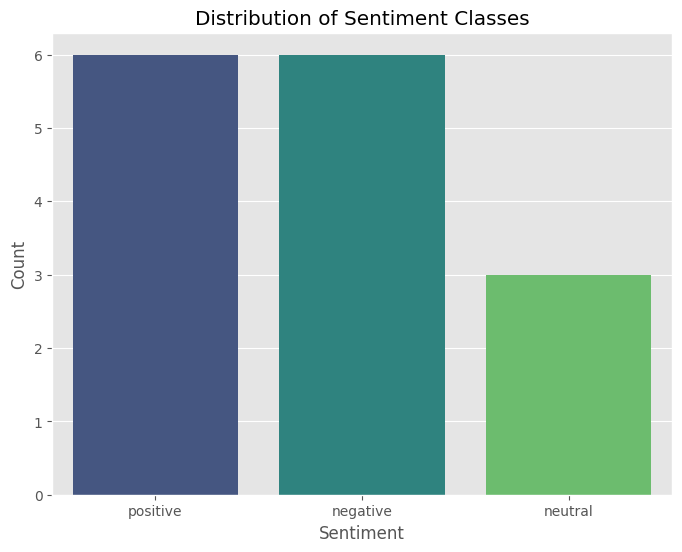

In [5]:
# Visualize sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## 3. Text Preprocessing

I perform the following preprocessing steps:
1. Convert text to lowercase
2. Remove special characters and numbers
3. Remove stopwords
4. Lemmatization

In [6]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into text
    processed_text = ' '.join(tokens)
    
    return processed_text

In [7]:
# Apply preprocessing to the reviews
df['processed_review'] = df['review'].apply(preprocess_text)

# Display original and processed reviews
pd.set_option('display.max_colwidth', None)
df[['review', 'processed_review']].head()

,review,processed_review
0,This product is amazing! I love it so much.,product amazing love much
1,Worst purchase ever. Complete waste of money.,worst purchase ever complete waste money
2,The quality is good but shipping took too long.,quality good shipping took long
3,"I'm very satisfied with my purchase, would buy again.",im satisfied purchase would buy
4,"Terrible customer service, will never shop here again.",terrible customer service never shop


## 4. Feature Engineering with TF-IDF Vectorization

TF-IDF (Term Frequency-Inverse Document Frequency) is a numerical statistic that reflects how important a word is to a document in a collection. I use it to convert text data into numerical features.

In [8]:
# Split the data into training and testing sets
X = df['processed_review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 10
Testing set size: 5


In [9]:
# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, min_df=2, max_df=0.8)

# Transform the training and testing data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF training matrix shape: {X_train_tfidf.shape}")
print(f"TF-IDF testing matrix shape: {X_test_tfidf.shape}")

TF-IDF training matrix shape: (10, 4)
TF-IDF testing matrix shape: (5, 4)


In [10]:
# Display the feature names (words) from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Number of features: {len(feature_names)}")
print(f"Sample features: {feature_names[:20]}")

Number of features: 4
Sample features: ['love' 'much' 'product' 'purchase']


## 5. Model Training with Logistic Regression

I use Logistic Regression for our sentiment classification task.

In [11]:
# Initialize and train the Logistic Regression model
lr_model = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.4000


## 6. Model Evaluation

In [12]:
# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

    negative       0.33      0.50      0.40         2
     neutral       0.00      0.00      0.00         1
    positive       0.50      0.50      0.50         2

    accuracy                           0.40         5
   macro avg       0.28      0.33      0.30         5
weighted avg       0.33      0.40      0.36         5



c:\python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


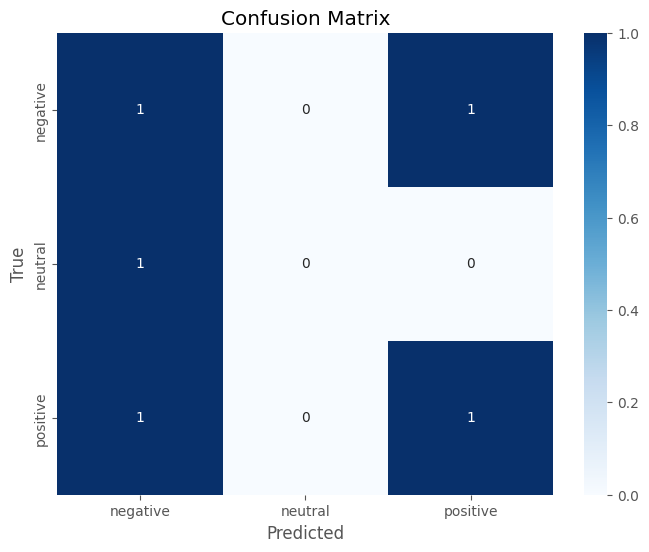

In [13]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lr_model.classes_, yticklabels=lr_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 7. Feature Importance Analysis

Let's examine which words are most important for each sentiment class.

In [14]:
def display_important_features(model, feature_names, class_labels, n=10):
    """Display the most important features for each class."""
    for i, class_label in enumerate(class_labels):
        print(f"\nTop {n} features for class '{class_label}':")
        
        # Get the coefficients for the current class
        if len(class_labels) == 2 and i == 0:
            # For binary classification, the first class has negative coefficients
            indices = np.argsort(model.coef_[0])
            indices = indices[:n]
        else:
            # For multiclass, each class has its own coefficients
            indices = np.argsort(model.coef_[i])
            indices = indices[-n:]
            
        for idx in reversed(indices):
            print(f"{feature_names[idx]}: {model.coef_[i if len(class_labels) > 2 else 0][idx]:.4f}")

In [15]:
# Display important features for each sentiment class
display_important_features(lr_model, feature_names, lr_model.classes_)


Top 10 features for class 'negative':
much: 0.2706
purchase: 0.2549
love: -0.4007
product: -0.5123

Top 10 features for class 'neutral':
product: 0.2260
love: -0.2033
purchase: -0.2493
much: -0.2554

Top 10 features for class 'positive':
love: 0.6040
product: 0.2863
purchase: -0.0056
much: -0.0152


## 8. Testing with New Reviews

In [16]:
def predict_sentiment(review, vectorizer, model):
    """Predict the sentiment of a new review."""
    # Preprocess the review
    processed_review = preprocess_text(review)
    
    # Vectorize the review
    review_tfidf = vectorizer.transform([processed_review])
    
    # Predict sentiment
    sentiment = model.predict(review_tfidf)[0]
    
    # Get probability scores
    proba = model.predict_proba(review_tfidf)[0]
    
    return sentiment, proba

In [17]:
# Test with new reviews
new_reviews = [
    "This product is absolutely fantastic! Best purchase I've made all year.",
    "I regret buying this. It broke after one week.",
    "The product is okay, but I expected more features for the price."
]

for review in new_reviews:
    sentiment, proba = predict_sentiment(review, tfidf_vectorizer, lr_model)
    print(f"Review: {review}")
    print(f"Predicted sentiment: {sentiment}")
    print(f"Probability distribution: {dict(zip(lr_model.classes_, proba))}")
    print("---")

Review: This product is absolutely fantastic! Best purchase I've made all year.
Predicted sentiment: negative
Probability distribution: {'negative': 0.4194730709478998, 'neutral': 0.18901606461015588, 'positive': 0.39151086444194433}
---
Review: I regret buying this. It broke after one week.
Predicted sentiment: negative
Probability distribution: {'negative': 0.45916330740535355, 'neutral': 0.2049598184570098, 'positive': 0.33587687413763667}
---
Review: The product is okay, but I expected more features for the price.
Predicted sentiment: positive
Probability distribution: {'negative': 0.2809367700819253, 'neutral': 0.2623802304498741, 'positive': 0.45668299946820057}
---


## 9. Conclusion

In this notebook, I've demonstrated sentiment analysis on customer reviews using TF-IDF vectorization and Logistic Regression. The key steps included:

1. Data loading and exploration
2. Text preprocessing (lowercase conversion, special character removal, stopword removal, lemmatization)
3. Feature engineering with TF-IDF vectorization
4. Model training with Logistic Regression
5. Model evaluation using accuracy, classification report, and confusion matrix
6. Feature importance analysis
7. Testing the model with new reviews
